<a href="https://colab.research.google.com/github/eminshall/QuantFinanceWorkbooks/blob/main/Forecasting_Gold_with_Meta_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nasdaq-data-link prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import nasdaqdatalink
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

nasdaqdatalink.ApiConfig.api_key = 'CwY-5k66sGHxnpTUptM-'

In [12]:
df = nasdaqdatalink.get(
    dataset='WGC/GOLD_DAILY_USD',
    start_date='2015-01-01',
    end_date='2019-12-31'
)

<Axes: title={'center': 'Daily Gold Prices (2015-2020)'}, xlabel='Date'>

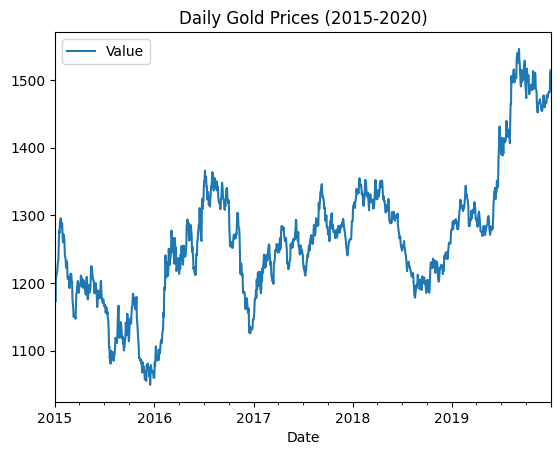

In [13]:
df.plot(title='Daily Gold Prices (2015-2020)')

In [14]:
df = df.reset_index(drop=False)
df.columns= ['ds', 'y']

In [17]:
#Arbitrarily Choose to use the last quarter as test data
train_indices = df['ds'] < '2019-10-01'
df_train = df.loc[train_indices].dropna()
df_test = (
    df.loc[~train_indices].reset_index(drop=True)
)

In [18]:
df_test

,ds,y
0,2019-10-01,1473.45
1,2019-10-02,1492.60
2,2019-10-03,1517.10
3,2019-10-04,1499.15
4,2019-10-07,1501.25
...,...,...
61,2019-12-25,1482.10
62,2019-12-26,1482.10
63,2019-12-27,1511.50
64,2019-12-30,1514.75


In [19]:
prophet = Prophet(changepoint_range=0.9)
prophet.add_country_holidays(country_name='US')
prophet.add_seasonality(
    name='monthly',period=30.5,fourier_order=5
)

prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkoj3oxz/2u0v2pyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkoj3oxz/balqd3c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90688', 'data', 'file=/tmp/tmpgkoj3oxz/2u0v2pyz.json', 'init=/tmp/tmpgkoj3oxz/balqd3c5.json', 'output', 'file=/tmp/tmpgkoj3oxz/prophet_modela8slh9sj/prophet_model-20230605211205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
df_future = prophet.make_future_dataframe(
    periods=len(df_test), freq='B'
)

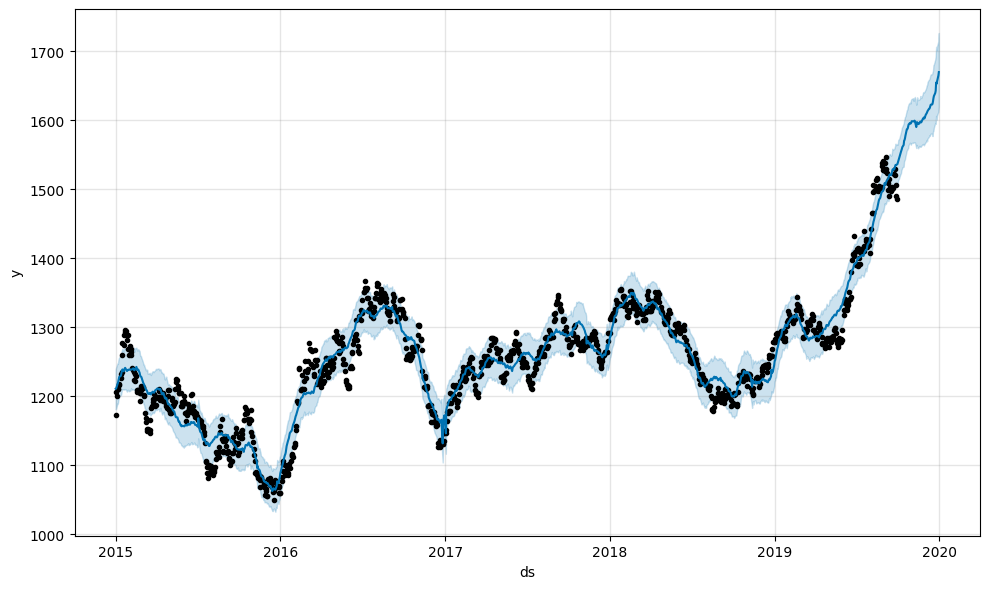

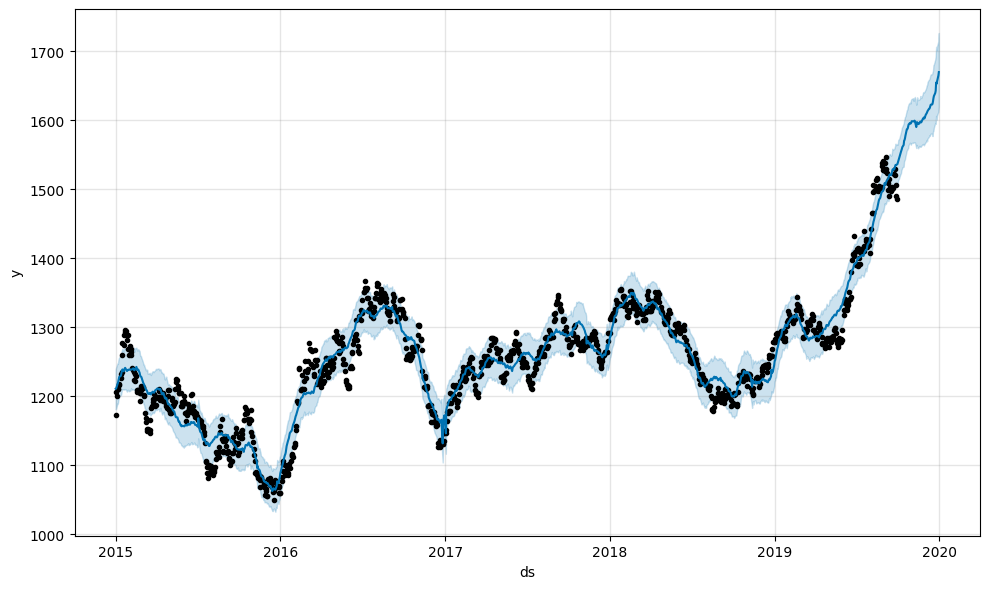

In [22]:
df_pred = prophet.predict(df_future)
prophet.plot(df_pred)

In [23]:
df_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

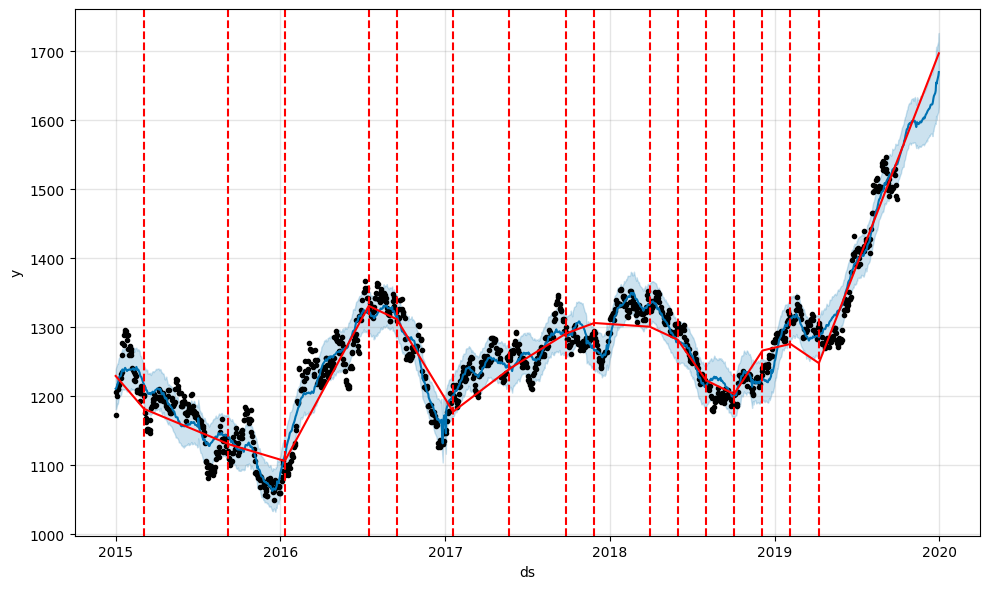

In [24]:
fig = prophet.plot(df_pred)
a = add_changepoints_to_plot(
    fig.gca(), prophet, df_pred
)

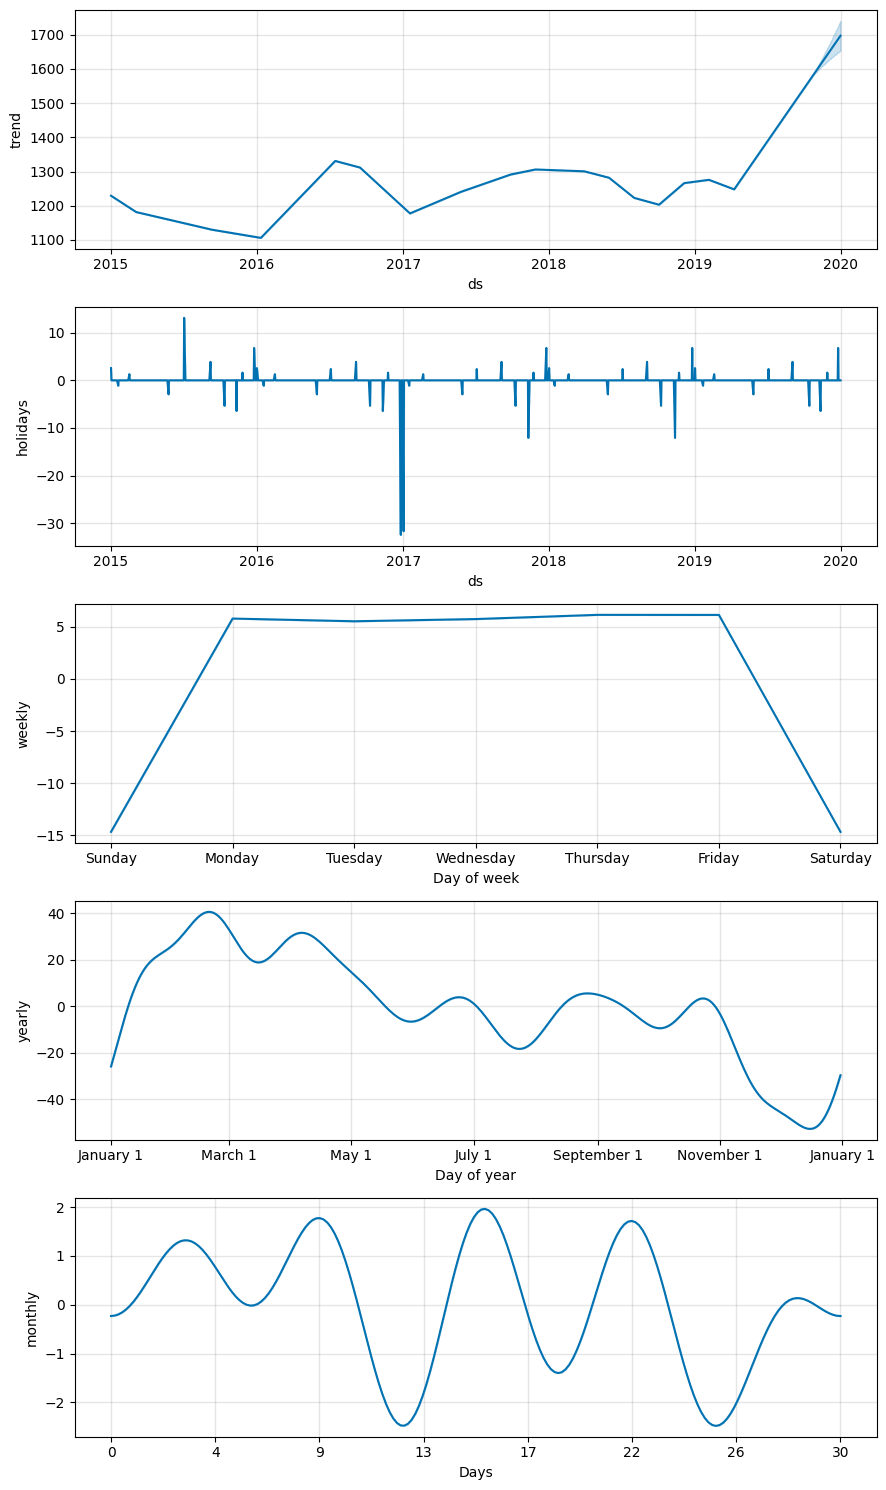

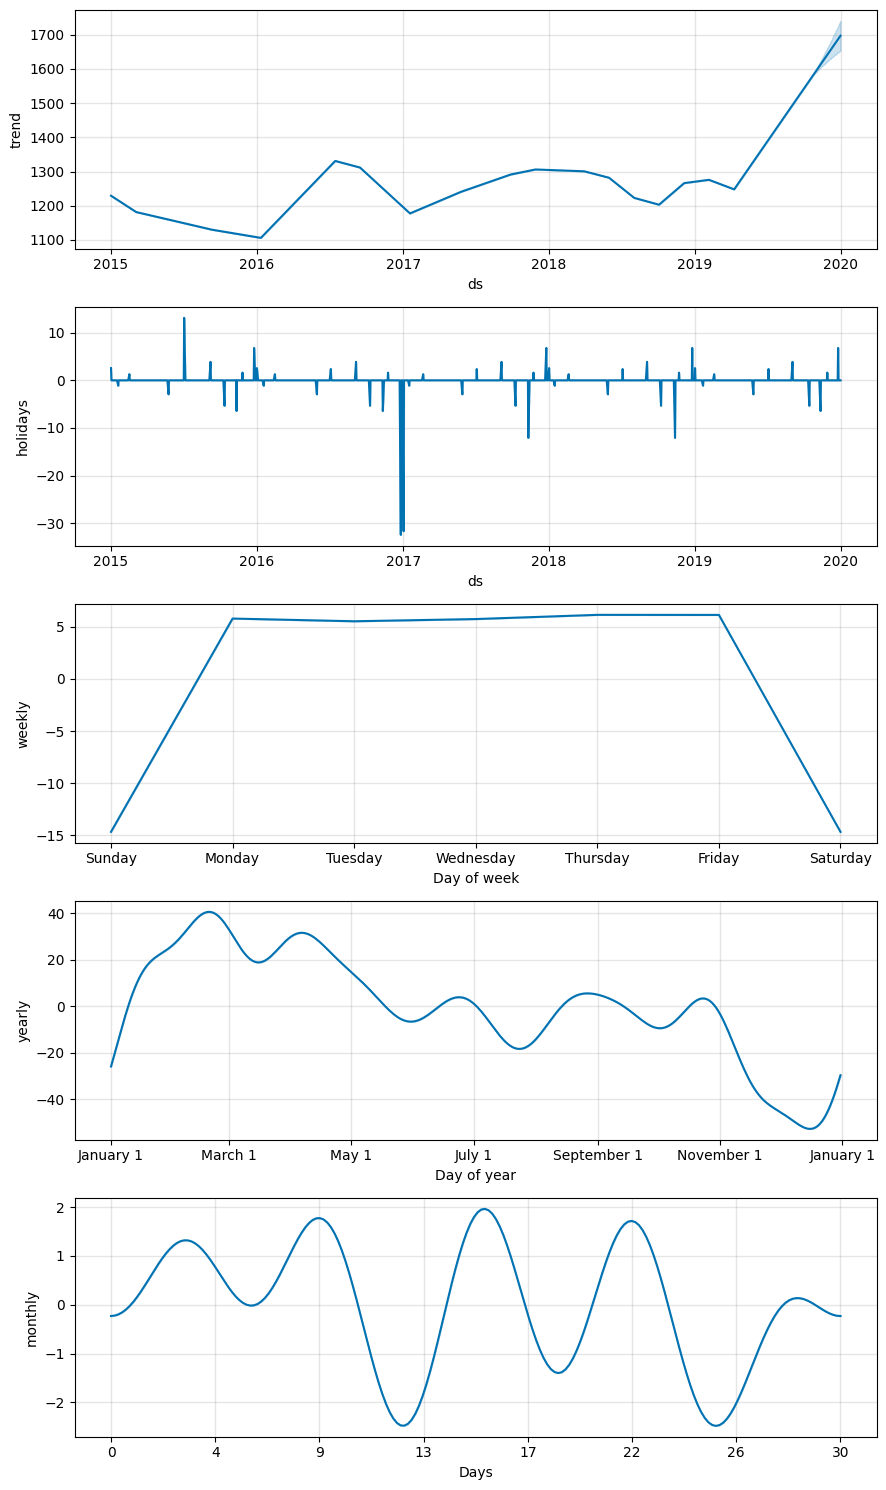

In [25]:
prophet.plot_components(df_pred)

In [26]:
SELECTED_COLS = [
    'ds','yhat','yhat_lower','yhat_upper'
]

df_pred = (
    df_pred.loc[:, SELECTED_COLS].reset_index(drop=True)
)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test['ds'] = pd.to_datetime(df_test['ds'])
df_test = df_test.set_index('ds')

In [55]:
df_test

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2019-10-01,1473.45,1538.364739,1509.438832,1564.560177
2019-10-02,1492.60,1541.120124,1513.228482,1571.201549
2019-10-03,1517.10,1543.390985,1514.110985,1572.053234
2019-10-04,1499.15,1544.916353,1515.723866,1572.620879
2019-10-07,1501.25,1551.986280,1521.911598,1579.928690
...,...,...,...,...
2019-12-25,1482.10,1654.400384,1606.234865,1706.273083
2019-12-26,1482.10,1652.683599,1600.521474,1701.016932
2019-12-27,1511.50,1656.068991,1606.745968,1706.958142


[Text(0.5, 1.0, 'Gold Price - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Gold Price ($)')]

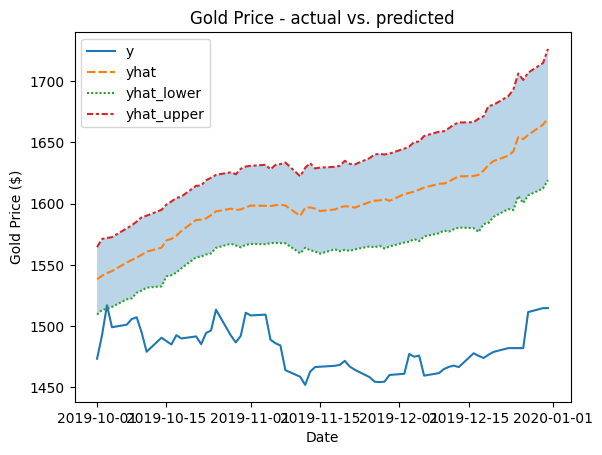

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,7))

PLOT_COLS = [
    'y','yhat','yhat_lower','yhat_upper'
]
ax = sns.lineplot(data=df_test[PLOT_COLS])
ax.fill_between(
    df_test.index,
    df_test['yhat_lower'],
    df_test['yhat_upper'],
    alpha=0.3
)
ax.set(
    title='Gold Price - actual vs. predicted',
    xlabel='Date',
    ylabel='Gold Price ($)'
)

In [43]:
from prophet.diagnostics import (cross_validation, performance_metrics)
from prophet.plot import plot_cross_validation_metric

df_cv = cross_validation(
    prophet,
    initial='756 days',
    period='60 days',
    horizon='60 days',
)

df_cv

INFO:prophet:Making 16 forecasts with cutoffs between 2017-02-12 00:00:00 and 2019-08-01 00:00:00


  0%|          | 0/16 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkoj3oxz/z58fsmw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkoj3oxz/dvtda5s0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70788', 'data', 'file=/tmp/tmpgkoj3oxz/z58fsmw8.json', 'init=/tmp/tmpgkoj3oxz/dvtda5s0.json', 'output', 'file=/tmp/tmpgkoj3oxz/prophet_modelc2nh4llb/prophet_model-20230605214311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkoj3oxz/3_btxq0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkoj3oxz/iz6isykq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,1239.802564,1214.279181,1265.255983,1222.25,2017-02-12
1,2017-02-14,1243.437875,1217.832513,1269.752974,1230.75,2017-02-12
2,2017-02-15,1245.207652,1217.877713,1272.486680,1224.40,2017-02-12
3,2017-02-16,1246.494419,1219.440429,1272.073118,1240.55,2017-02-12
4,2017-02-17,1246.383247,1219.726464,1271.991603,1241.95,2017-02-12
...,...,...,...,...,...,...
681,2019-09-24,1415.339717,1377.717777,1448.385876,1520.65,2019-08-01
682,2019-09-25,1415.490111,1375.910442,1452.209541,1528.75,2019-08-01
683,2019-09-26,1415.018259,1375.731166,1450.449085,1506.40,2019-08-01
684,2019-09-27,1413.333598,1372.875546,1452.000107,1489.90,2019-08-01


In [56]:
df_cv['ds'] = pd.to_datetime(df_cv['ds'])
df_cv = df_cv.set_index('ds')

[Text(0.5, 1.0, 'Prophet CV Gold Price - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Gold Price ($)')]

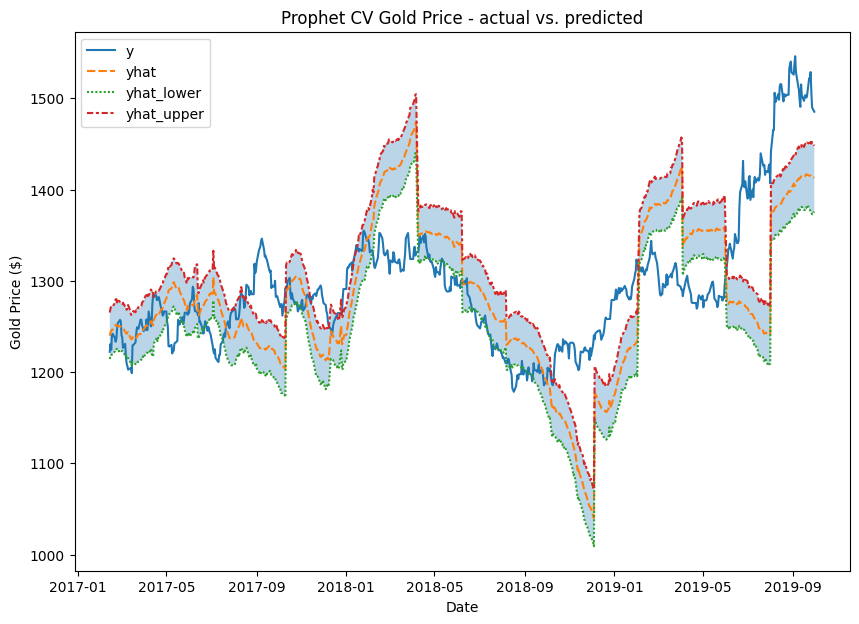

In [57]:
fig, ax = plt.subplots(figsize=(10,7))

PLOT_COLS = [
    'y','yhat','yhat_lower','yhat_upper'
]
ax = sns.lineplot(data=df_cv[PLOT_COLS])
ax.fill_between(
    df_cv.index,
    df_cv['yhat_lower'],
    df_cv['yhat_upper'],
    alpha=0.3
)
ax.set(
    title='Prophet CV Gold Price - actual vs. predicted',
    xlabel='Date',
    ylabel='Gold Price ($)'
)

In [31]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,1737.648875,41.685116,31.519076,0.024034,0.017111,0.024193,0.551471
1,7 days,1972.688771,44.414961,33.845136,0.025781,0.019762,0.026004,0.529412
2,8 days,2171.468229,46.599015,35.647877,0.027014,0.021402,0.027297,0.505348
3,9 days,2331.009593,48.280530,38.115142,0.028945,0.024740,0.029172,0.459559
4,10 days,2490.471968,49.904629,40.672788,0.031158,0.030866,0.031396,0.411765
5,11 days,2651.966704,51.497249,41.901985,0.032147,0.030866,0.032444,0.397059
6,12 days,2688.919512,51.854793,42.585713,0.032644,0.031413,0.032924,0.391711
7,13 days,2898.325318,53.836097,44.467025,0.034052,0.035038,0.034325,0.376225
8,14 days,3227.309085,56.809410,47.587706,0.036521,0.036144,0.036791,0.338235
9,15 days,3602.807593,60.023392,49.819828,0.037999,0.036572,0.038318,0.316845


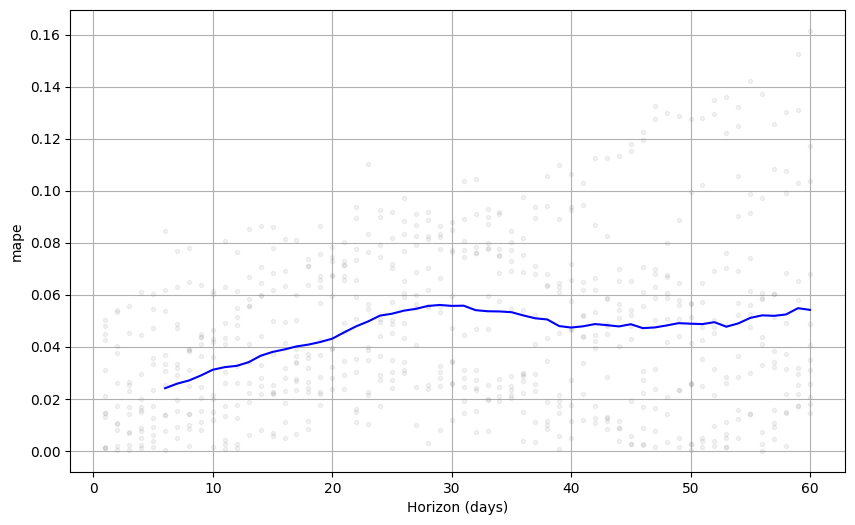

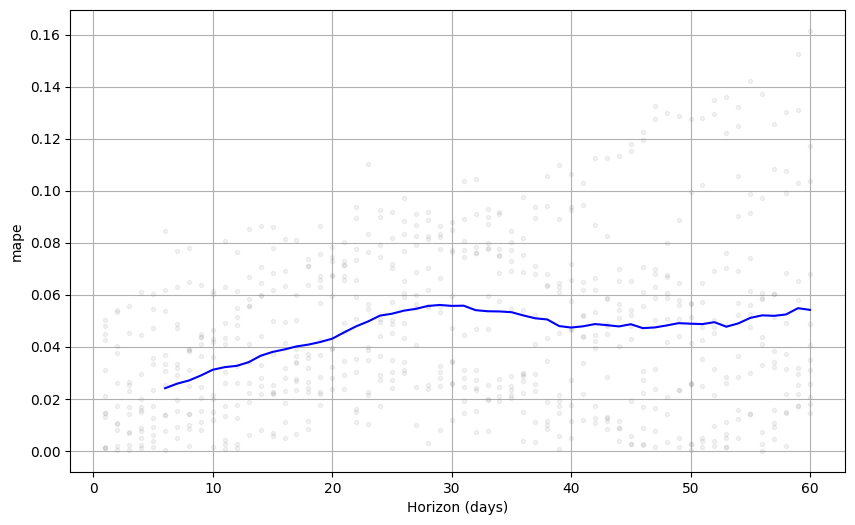

In [32]:
plot_cross_validation_metric(df_cv, metric='mape')